In [1]:
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

%matplotlib inline

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout, LSTM, Bidirectional

In [2]:
messages = pd.read_csv("emails2.csv")
messages.head()

,text,spam
0,Subject: enron methanol ; meter # : 988291\r\n...,0
1,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,"Subject: photoshop , windows , office . cheap ...",1
4,Subject: re : indian springs\r\nthis deal is t...,0


In [3]:
messages2 = pd.read_csv("spam_or_not_spam.csv")
messages2.rename({"email": "text", "label": "spam"}, axis = 1, inplace = True)
messages2.head()

,text,spam
0,date wed NUMBER aug NUMBER NUMBER NUMBER NUMB...,0
1,martin a posted tassos papadopoulos the greek ...,0
2,man threatens explosion in moscow thursday aug...,0
3,klez the virus that won t die already the most...,0
4,in adding cream to spaghetti carbonara which ...,0


In [4]:
messages3 = pd.read_csv("spam.csv")
messages3.rename({"Message": "text", "Category": "spam"}, axis = 1, inplace = True)
messages3.loc[messages3["spam"] == "spam", "spam"] = '1'
messages3.loc[messages3["spam"] == "ham", "spam"] = '0'
messages3.head()

,spam,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
messages = messages.append([messages2])

In [6]:
messages = messages.append([messages3])

display(messages)

,text,spam
0,Subject: enron methanol ; meter # : 988291\r\n...,0
1,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,"Subject: photoshop , windows , office . cheap ...",1
4,Subject: re : indian springs\r\nthis deal is t...,0
...,...,...
5567,This is the 2nd time we have tried 2 contact u...,1
5568,Will ü b going to esplanade fr home?,0
5569,"Pity, * was in mood for that. So...any other s...",0
5570,The guy did some bitching but I acted like i'd...,0


In [7]:
messages.shape

(19473, 2)

In [8]:
messages['spam'].astype(str)
messages.dtypes

text    object
spam    object
dtype: object

In [9]:
messages.shape

(19473, 2)

In [10]:
##Removing null values
messages = messages.dropna()

In [11]:
messages = messages[messages['spam'].isin(['0','1',0,1])]
non_spam_msg = messages[messages['spam'].isin(['0',0])]
spam_msg = messages[messages['spam'].isin(['1',1])]

non_spam_msg_txt = " ".join(non_spam_msg.text.to_numpy().tolist())
spam_msg_txt = " ".join(spam_msg.text.to_numpy().tolist())

In [12]:
non_spam_msg.text.dtype

dtype('O')

In [13]:
print(messages.shape)
print(messages.dtypes)
print(non_spam_msg.shape)
print(spam_msg.shape)

(19468, 2)
text    object
spam    object
dtype: object
(15355, 2)
(4113, 2)


In [14]:
#removing any html tags from the data.

messages['text'] = [BeautifulSoup(text).get_text() for text in messages['text'] ]

In [15]:
messages['spam']= messages['spam'].astype(float)
print(messages.dtypes)

text     object
spam    float64
dtype: object


In [16]:
#removing if any duplicates
messages.drop_duplicates(subset=None, keep='first', inplace=False, ignore_index=False)
messages.shape

(19468, 2)

The words which are generally filtered out before processing a natural language are called stop words. These are actually the most common words in any language (like articles, prepositions, pronouns, conjunctions, etc) and does not add much information to the text.

In [17]:
##Adding certain words like the name of the person, subject and extra stop words
stopwords = nltk.corpus.stopwords.words('english')
new_words=('Subject', 'subject', 'shirley','com', 'would', 'could', 'also', 'enron', 'ect','kaminski', 'vince', "number","url","hyperlink","list","spamassassin","rpm","date","freshrpms ", 'hou','mail')
for i in new_words:
    stopwords.append(i)
print(stopwords)


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [18]:
##Removing stop words from the text
messages['text'].apply(lambda x: [item for item in x if item not in stopwords])
messages['text']

0       Subject: enron methanol ; meter # : 988291\r\n...
1       Subject: hpl nom for january 9 , 2001\r\n( see...
2       Subject: neon retreat\r\nho ho ho , we ' re ar...
3       Subject: photoshop , windows , office . cheap ...
4       Subject: re : indian springs\r\nthis deal is t...
                              ...                        
5567    This is the 2nd time we have tried 2 contact u...
5568                 Will ü b going to esplanade fr home?
5569    Pity, * was in mood for that. So...any other s...
5570    The guy did some bitching but I acted like i'd...
5571                           Rofl. Its true to its name
Name: text, Length: 19468, dtype: object

In [19]:
from collections import Counter
split_it = non_spam_msg_txt.split()

# Pass the split_it list to instance of Counter class.
Counters_found = Counter(split_it)
#print(Counters)
most_occur = Counters_found.most_common(100)
print('Most occuring words in non-spam messages:')
print(most_occur)

Most occuring words in non-spam messages:
[('-', 174296), ('.', 107457), ('the', 82263), (',', 78258), ('/', 74775), ('to', 63241), (':', 58124), ('and', 40072), ('of', 34584), ('a', 32443), ('i', 29246), ('>', 27556), ('for', 26586), ('in', 26483), ('NUMBER', 26252), ('@', 26148), ('ect', 25315), ('you', 24835), ('on', 21459), ('is', 21449), ('enron', 19779), ('that', 17386), ('this', 15783), ('be', 14388), ("'", 14040), ('it', 13697), (')', 13464), ('with', 12949), ('hou', 12850), ('(', 12458), ('have', 12351), ('we', 12020), ('will', 11721), ('?', 11396), ('at', 11394), ('s', 11327), ('from', 11122), ('"', 10037), ('are', 9918), ('as', 9504), ('2000', 9238), ('your', 9171), ('if', 9040), ('by', 8855), ('vince', 8535), ('Subject:', 8030), ('not', 7925), ('or', 7760), ('am', 7759), ('com', 7529), ('me', 7424), ('subject', 7364), ('please', 7303), ('*', 7166), ('can', 6975), ('URL', 6815), ('cc', 6345), ('re', 6246), ('would', 6098), ('pm', 5800), ('my', 5751), ('_', 5630), (';', 5629)

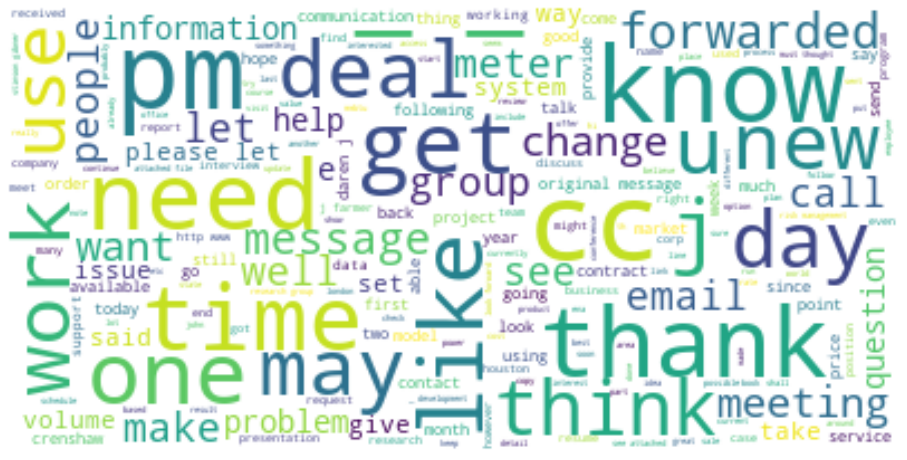

In [20]:
non_spam_msg_wcloud = WordCloud(stopwords=stopwords,max_font_size=50, background_color ="white").generate(non_spam_msg_txt)
plt.figure(figsize=(16,10))
plt.imshow(non_spam_msg_wcloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.show()

Most common words in non- spam emails are: pm, work, thank, need, know, cc, think, day, meeting, information, want, message, people, group

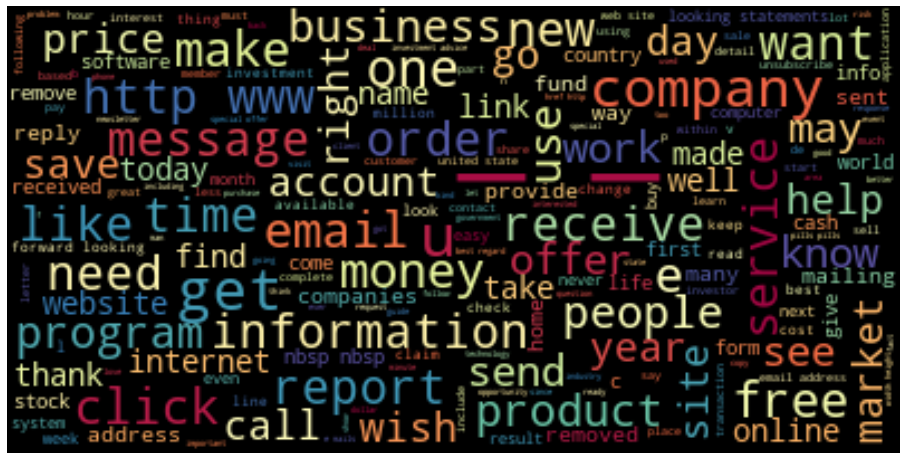

In [21]:
# wordcloud of spam messages
spam_msg_wcloud = WordCloud(stopwords=stopwords,max_font_size=50, background_color ="black", colormap='Spectral_r').generate(spam_msg_txt)
plt.figure(figsize=(16,10))
plt.imshow(spam_msg_wcloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.show()

Most common words in spam emails are: Click, Offer, free, company, business, order, price, need, people, call, new, get, save, service etc

In [22]:
split_it = spam_msg_txt.split()

# Pass the split_it list to instance of Counter class.
Counters_found = Counter(split_it)
#print(Counters)

# most_common() produces k frequently encountered
# input values and their respective counts.
most_occur = Counters_found.most_common(100)
print('Most occuring words in non-spam messages:')
print(most_occur)

Most occuring words in non-spam messages:
[('.', 39341), (',', 22742), ('the', 22187), ('to', 18828), ('-', 16508), ('and', 15261), ('_', 14821), ('of', 13784), ('you', 11390), ('a', 11342), (':', 9303), ('in', 9220), ('/', 8286), ('for', 7922), ('your', 7759), ('NUMBER', 7210), ('is', 6986), ('this', 6916), ('!', 5776), ('that', 4450), ('with', 4313), ('i', 4294), ('=', 4278), ("'", 4088), ('or', 4050), ('be', 3925), ('on', 3913), ('$', 3908), ('are', 3769), ('we', 3723), ('it', 3683), ('from', 3449), ('s', 3413), ('our', 3285), ('as', 3248), ('not', 3233), ('have', 3186), (')', 3149), ('(', 3027), ('will', 3020), ('?', 2915), ('Subject:', 2867), ('all', 2492), ('by', 2374), ('*', 2226), ('at', 2203), ('"', 2160), ('if', 2122), ('|', 2098), ('com', 2027), ('can', 2015), ('no', 1981), ('an', 1886), ('e', 1879), ('3', 1860), ('here', 1826), ('email', 1804), ('more', 1798), ('%', 1764), ('company', 1736), ('1', 1702), ('free', 1692), ('http', 1671), ('my', 1664), ('do', 1660), ('2', 1640

In [23]:
# Split data into train and test
train_msg, test_msg, train_labels, test_labels = train_test_split(messages['text'], messages['spam'], test_size=0.2, random_state=500)

In [24]:
tokenizer = Tokenizer(num_words = 500, char_level=False, oov_token = "<OOV>")
tokenizer.fit_on_texts(train_msg)

In [25]:
# Get the word_index 
word_index = tokenizer.word_index
word_index

{'<OOV>': 1,
 'the': 2,
 'to': 3,
 'and': 4,
 'of': 5,
 'a': 6,
 'you': 7,
 'in': 8,
 'i': 9,
 'number': 10,
 'for': 11,
 '\r': 12,
 'is': 13,
 'on': 14,
 'ect': 15,
 'this': 16,
 'that': 17,
 'enron': 18,
 'subject': 19,
 "'": 20,
 'be': 21,
 'it': 22,
 'with': 23,
 'your': 24,
 'we': 25,
 'have': 26,
 'will': 27,
 's': 28,
 'from': 29,
 'are': 30,
 'at': 31,
 'hou': 32,
 'as': 33,
 'or': 34,
 'if': 35,
 'by': 36,
 'not': 37,
 'can': 38,
 'com': 39,
 'me': 40,
 'url': 41,
 'please': 42,
 'vince': 43,
 '2000': 44,
 'our': 45,
 'my': 46,
 'an': 47,
 'all': 48,
 'am': 49,
 'would': 50,
 're': 51,
 'cc': 52,
 't': 53,
 'was': 54,
 '1': 55,
 'but': 56,
 'has': 57,
 'any': 58,
 'do': 59,
 '2': 60,
 '3': 61,
 'j': 62,
 'get': 63,
 'time': 64,
 'so': 65,
 'know': 66,
 'e': 67,
 'new': 68,
 'about': 69,
 'one': 70,
 'up': 71,
 'no': 72,
 'they': 73,
 'kaminski': 74,
 '10': 75,
 'there': 76,
 'more': 77,
 '2001': 78,
 'thanks': 79,
 'what': 80,
 'pm': 81,
 'out': 82,
 'may': 83,
 'like': 84,
 '

In [26]:
tot_words = len(word_index)
print('There are %s unique tokens in training data. ' % tot_words)

There are 88808 unique tokens in training data. 


In [27]:
# Sequencing and padding 
#train
training_sequences = tokenizer.texts_to_sequences(train_msg)
training_padded = pad_sequences (training_sequences, maxlen = 50, padding = "post", truncating = "post" )

#test
testing_sequences = tokenizer.texts_to_sequences(test_msg)
testing_padded = pad_sequences(testing_sequences, maxlen = 50,padding = "post", truncating = "post" )

In [28]:
#Dense Sequential model architecture
model = Sequential()
model.add(Embedding(500, 15, input_length=50))
model.add(GlobalAveragePooling1D())
model.add(Dense(24, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 15)            7500      
                                                                 
 global_average_pooling1d (G  (None, 15)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 24)                384       
                                                                 
 dropout (Dropout)           (None, 24)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 7,909
Trainable params: 7,909
Non-trainable params: 0
______________________________________________________

In [30]:
model.compile(loss='binary_crossentropy',optimizer='adam' ,metrics=['accuracy'])

In [31]:
# fit dense seq model
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(training_padded, train_labels, epochs=num_epochs, validation_data=(testing_padded, test_labels),callbacks =[early_stop], verbose=2)

Epoch 1/30
487/487 - 1s - loss: 0.4219 - accuracy: 0.8275 - val_loss: 0.2422 - val_accuracy: 0.9096 - 990ms/epoch - 2ms/step
Epoch 2/30
487/487 - 1s - loss: 0.2051 - accuracy: 0.9223 - val_loss: 0.1798 - val_accuracy: 0.9276 - 514ms/epoch - 1ms/step
Epoch 3/30
487/487 - 0s - loss: 0.1686 - accuracy: 0.9381 - val_loss: 0.1606 - val_accuracy: 0.9386 - 473ms/epoch - 972us/step
Epoch 4/30
487/487 - 1s - loss: 0.1489 - accuracy: 0.9462 - val_loss: 0.1510 - val_accuracy: 0.9420 - 508ms/epoch - 1ms/step
Epoch 5/30
487/487 - 0s - loss: 0.1397 - accuracy: 0.9491 - val_loss: 0.1462 - val_accuracy: 0.9466 - 476ms/epoch - 978us/step
Epoch 6/30
487/487 - 1s - loss: 0.1316 - accuracy: 0.9522 - val_loss: 0.1495 - val_accuracy: 0.9456 - 510ms/epoch - 1ms/step
Epoch 7/30
487/487 - 0s - loss: 0.1268 - accuracy: 0.9544 - val_loss: 0.1428 - val_accuracy: 0.9492 - 490ms/epoch - 1ms/step
Epoch 8/30
487/487 - 1s - loss: 0.1229 - accuracy: 0.9556 - val_loss: 0.1416 - val_accuracy: 0.9517 - 504ms/epoch - 1ms/s

In [32]:
y_predict = [1 if o>0.5 else 0 for o in model.predict(testing_padded)]

In [33]:
from sklearn.metrics import confusion_matrix,f1_score, precision_score,recall_score
cf_matrix =confusion_matrix(test_labels,y_predict)
tn, fp, fn, tp = confusion_matrix(test_labels,y_predict).ravel()
print("Precision: {:.2f}%".format(100 * precision_score(test_labels, y_predict)))
print("Recall: {:.2f}%".format(100 * recall_score(test_labels, y_predict)))
print("F1 Score: {:.2f}%".format(100 * f1_score(test_labels,y_predict)))

Precision: 89.91%
Recall: 85.70%
F1 Score: 87.75%


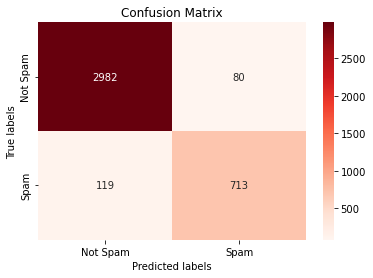

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt
ax= plt.subplot()
#annot=True to annotate cells
sns.heatmap(cf_matrix, annot=True, ax = ax,cmap='Reds',fmt='');
# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['Not Spam', 'Spam']); ax.yaxis.set_ticklabels(['Not Spam', 'Spam']);

In [35]:
model.compile(loss='binary_crossentropy',optimizer='adam' ,metrics=['accuracy'])
model.evaluate(testing_padded, test_labels)

122/122 [==============================] - 0s 768us/step - loss: 0.1451 - accuracy: 0.9489


[0.14507834613323212, 0.9488957524299622]

Accuracy is ~ 95% and Loss is ~14%